In [1]:
try:
    from sklearnex import patch_sklearn, unpatch_sklearn
    patch_sklearn()
except:
    pass

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


説明変数 = temperature, sunhour1, sunhour2, insolation, month, hour, dayofweek
検証スコア = 0.902975


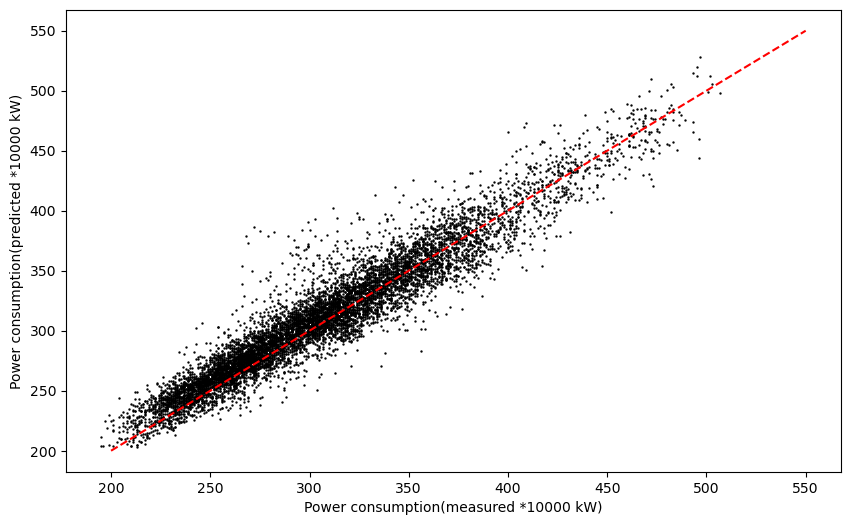

In [2]:
# coding: utf-8
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import joblib

# 祝日を日曜日(dayofweek=6)に設定する関数
def set_holiday(takamatsu, year_from = "2017", year_to = "2020"):
    holiday = pd.read_csv(
    'data/syukujitsu.csv',
    skiprows=1,
    names=['DATE', 'HOLIDAY-NAME'],
    parse_dates={'date': ['DATE']},
    index_col = "date",
    encoding='cp932')

    holiday["holiday"] = holiday.index

    from_ = "{}-01-01".format(year_from)
    to_ = "{}-12-31".format(year_to)
    holiday_year = holiday.loc[from_: to_,"holiday"]

    for hly in holiday_year:
        # 祝日を日曜日(6)に設定する
        ymd = pd.to_datetime(hly)
        takamatsu.loc[ymd.strftime('%Y-%m-%d'),["dayofweek"]]=6.0

    return takamatsu.dropna()

# 四国電力の電力消費量データを読み込み
ed = [pd.read_csv(
    'data/juyo_shikoku_{:d}.csv'.format(year),
    skiprows=3,
    names=['DATE', 'TIME', 'consumption'],
    parse_dates={'date_hour': ['DATE', 'TIME']},
    index_col = "date_hour")
    for year in [2021]
]
elec_data = pd.concat(ed)

# 複数年の気象データを読み込み
tp = [pd.read_csv(
    './data/takamatsu{:d}.csv'.format(year),
    skiprows=5,
    names=['DATETIME', 'temperature', 'temperature2', 'temperature3', 
           'sunhour1','sunhour2','sunhour3','sunhour4',
           'insolation','insolation2','insolation3',
           'humid','humid2','humid3'],
    parse_dates={'date_hour': ["DATETIME"]},
    index_col='date_hour')
    for year in [2021]
]

tmp = pd.concat(tp)

# 月, 日, 時の取得
tmp["month"] = tmp.index.month
tmp['day'] = tmp.index.day
tmp['dayofyear'] = tmp.index.dayofyear
tmp['hour'] = tmp.index.hour
tmp['dayofweek'] = tmp.index.dayofweek

# 気象データと電力消費量データをいったん統合して時間軸を合わせたうえで、再度分割
#variable = ["temperature","sunhour1","month","hour"]
variable = ["temperature","sunhour1","sunhour2","insolation","month","hour","dayofweek"]
# variable = ["temperature","month","hour","dayofweek"]

# takamatsu_wthr = elec_data.join(tmp[variable]).dropna()
takamatsu_tmp = elec_data.join(tmp[variable]).dropna()
# 祝日を日曜日(6)に変換
takamatsu_wthr = set_holiday(takamatsu_tmp, year_from=2021, year_to=2021)

###
# dmy_dayofweek =pd.get_dummies( takamatsu_wthr['dayofweek'], prefix='dwk',prefix_sep='_',drop_first=True)
# takamatsu_wthr = pd.concat([takamatsu_wthr,dmy_dayofweek], axis=1)
# takamatsu_wthr = takamatsu_wthr.drop('dayofweek',axis=1)

# dmy_hour =pd.get_dummies( takamatsu_wthr['hour'], prefix='h',prefix_sep='_',drop_first=True)
# takamatsu_wthr = pd.concat([takamatsu_wthr,dmy_hour], axis=1)
# takamatsu_wthr = takamatsu_wthr.drop('hour',axis=1)

# dmy_month =pd.get_dummies( takamatsu_wthr['month'], prefix='m',prefix_sep='_',drop_first=True)
# takamatsu_wthr = pd.concat([takamatsu_wthr,dmy_month], axis=1)
# takamatsu_wthr = takamatsu_wthr.drop('month',axis=1)
###
takamatsu_elec = takamatsu_wthr.pop("consumption")

# model 読み込み
filename ='weather-elec-svr-gs.pkl'
model = joblib.load(filename)

# テストデータ作成
x_test = takamatsu_wthr
y_test = takamatsu_elec

# テストデータを標準化
filename ='scaler-svr-gs.pkl'
scaler = joblib.load(filename)
x_test_normed = scaler.transform(x_test)

filename ='scaler2-svr-gs.pkl'
scaler2 = joblib.load(filename)
y_test_normed = scaler2.transform(pd.DataFrame(y_test))

score = "説明変数 = {}\n検証スコア = {:f}".format(
          ", ".join(variable),
#           model.score(x_train_normed, y_train_normed),
          model.score(x_test_normed, y_test_normed)
          )

print (score)

# -- 可視化 --
# 画像のサイズを設定する
plt.figure(figsize=(10, 6))

predicted = model.predict(x_test_normed)

plt.xlabel('Power consumption(measured *10000 kW)')
plt.ylabel('Power consumption(predicted *10000 kW)')
plt.scatter(scaler2.inverse_transform(y_test_normed), scaler2.inverse_transform(predicted.reshape(-1,1)), s=0.5, color="black")
plt.plot([200, 550], [200, 550], 'r--')

#plt.savefig("predict-power-consumption-graph.png")
plt.show()


### 測定値と予測値を折れ線グラフで可視化

開始月日 mm/nn :1/1
Start date-time : 2021-01-01 01:00:00


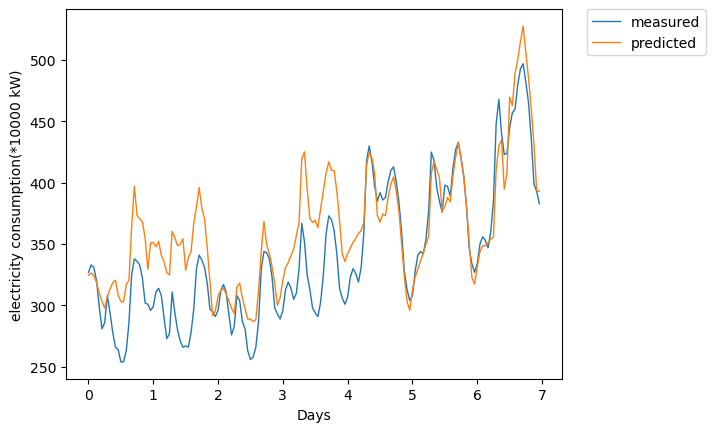

In [3]:
# 標準化データを標準化前に逆変換
pred = scaler2.inverse_transform(predicted.reshape(-1,1)).reshape(-1)
# 予測結果に時系列インデックス(DatetimeIndex)を付加したPandas Seriesを作成
sr_predicted = pd.Series(pred,index=takamatsu_wthr.index, name='predict')
# 電力消費量の計測値と予測値を結合
measure_predict = pd.DataFrame(takamatsu_elec).join(sr_predicted)
try:
    # 表示開始インデックスの指定
    str_ = input("開始月日 mm/nn :")
    date_str = "2021-" + str_ + " 01:00:00"
    measure_predict.index.get_loc(pd.to_datetime(date_str))
except (KeyError, ValueError):
    print("開始日が不正のため2021-01-01 01:00:00で開始します。")
    date_str = "2021-01-01 01:00:00"   

# 開始日の設定
start_index = measure_predict.index.get_loc(pd.to_datetime(date_str))

# 表示期間を開始日から７日間に設定
end_index = start_index + 24*7
if start_index + 24*7 > len(measure_predict):
    # 年末は終了日を12/31に設定
    end_index = len(measure_predict)

delta = measure_predict.index - pd.to_datetime(str(measure_predict.index[:1][0]))
print("Start date-time :",str(measure_predict.index[start_index:start_index+1][0]))

# グラフ横軸の単位を1/24=0.041667にするtime列を追加
measure_predict['time'] = delta.days + delta.seconds / 3600.0 / 24.0
# 以下グラフ生成
plt.xlabel('Days')
plt.ylabel('electricity consumption(*10000 kW)')

plt.plot(measure_predict[start_index:end_index].time,measure_predict.consumption[start_index:end_index], linewidth=1,
         label='measured')
plt.plot(measure_predict[start_index:end_index].time,measure_predict.predict[start_index:end_index], linewidth=1,
         label='predicted')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()